In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

# Data

The first three steps in data science are to:
* find your data
* look at your data
* clean your data

Today we will keep working with the set of Craigslist listings for used Mazda 3s. (!!)

This dataset is the Mazda 3 subset from https://www.kaggle.com/austinreese/craigslist-carstrucks-data after some cleanup (basically, I selected all the variants of Mazda 3 in the model column, and then removed some columns).

Take a look at it in data/mazdas.csv!

Now we will load this dataset. I'm going to load it the unpleasant way (rather than using the Data class), because I want to use those nonnumeric colums. 

Because our numpy arrays all have to be the same type, we first need to:
* figure out which columns we want
* define some converters

In [3]:
# this just does pattern matching
import re

def conditionConverter(x):
    values = ['', 'new', 'like new', 'excellent', 'good', 'fair', 'salvage']
    return values.index(x)

def titleConverter(x):
    values = ['', 'clean', 'lien', 'rebuilt','salvage']
    return values.index(x)

def transmissionConverter(x):
    values = ['', 'automatic', 'manual', 'other']
    return values.index(x)

def typeConverter(x):
    if re.match(r'(sedan|coupe)', x):
        return 1
    elif re.match(r'(mini-van|hatchback|wagon|SUV)', x):
        return 2
    return 0

def colorConverter(x):
    values = ['', 'grey', 'white', 'black', 'blue', 'orange', 'purple', 'red', 'green', 'brown', 'custom', 'silver']
    if x in values:
        return values.index(x)
    else:
        print("couldn't find |" + x + "|")
        return 0

In [4]:
# Load the data
# This dataset is the mazda subsample from https://www.kaggle.com/austinreese/craigslist-carstrucks-data after some cleanup

columns = ["price", "age", "condition", "odometer", "title_type", "transmission", "type", "color"]
data = np.array(np.genfromtxt('data/mazdas.csv', delimiter=',', usecols=(1,2,5,6,7,8,9,10), converters={5: conditionConverter, 7: titleConverter, 8: transmissionConverter, 9: typeConverter, 10: colorConverter}, skip_header=2, dtype=int, encoding='utf-8'))  
print(data)

[[ 6900  2010     4 ...     1     1     1]
 [16306  2017     0 ...     1     1     7]
 [  800  2006     5 ...     1     1     1]
 ...
 [ 5495  2008     0 ...     1     0     0]
 [ 7500  2012     0 ...     1     1     3]
 [10800  2019     0 ...     1     1     3]]


Let's do a pairplot so we can see what's going on.

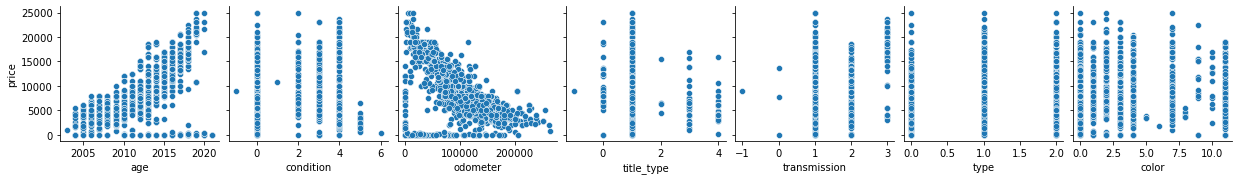

In [5]:
df = pd.DataFrame(data, columns=columns)
seaborn.pairplot(df, y_vars = columns[0], x_vars = columns[1:])

plt.show()

Let's get some summary statistics.

In [6]:
def getSummaryStatistics(data):
    return np.array([data.max(axis=0), data.min(axis=0), data.mean(axis=0, dtype=int)])

def getShapeType(data):
    return (data.shape, data.dtype)

print(getSummaryStatistics(data))
print(getShapeType(data))
print(data[0])

[[ 25000   2021      6 264000      4      3      2     11]
 [     0   2003     -1     -1     -1     -1      0      0]
 [  8810   2012      2  96565      1      1      1      3]]
((1498, 8), dtype('int32'))
[  6900   2010      4 165255      3      1      1      1]


Let's calculate *correlations* between price and the other variables. (Remind me what correlation values vary between?)

** Consider: correlations between *all pairs of variables*

In [7]:
for i in range(len(columns)):
    print(columns[i], np.corrcoef(data[:, 0], data[:, i], rowvar=True)[0,1])

price 0.9999999999999999
age 0.634628924104239
condition 0.27495847661424677
odometer -0.5852759802512562
title_type -0.09682527301456303
transmission 0.505686368902948
type 0.2979508537024295
color 0.10120003527483128


## Let's review regression

Regression allows us to:
* determine the *nature* of a relationship between one (or more!) independent variables and a dependent variable
* determine the *strength* of the relationship

Regression *fits* a function to a dataset.

Regression is *not* the same as interpolation: we don't want to fit so closely that we exactly pass through each data point, but rather fit so that we generalize over the data. Why is this?
* because the data sets we have are not *all* the data, but a *sample* of the data, and other samples may be somewhat different
* because we want to be able to *explain* relationships between variables

Both of these require some generalization/abstraction away from the actual data.

Okay, so we need some functions; we need a method for making the function "fit" the data; and we need a measure of how "good" the fit is. 

## What kinds of functions can we fit? 

We are going to start with *linear regression*. What type of function do we fit when we do linear regression? A linear function! You might see it written like $$F(x_i) = b + mx_i$$ or like $$\hat{y}_i = b+ mx_i$$It's called linear because when you plot it you get a line that crosses 0 at $b$ (the "intercept") and has slope $m$.

Note that this function tries to calculate one variable ($y$) as a function of one other variable ($x$). Next week, we will look at functions that calculate $y$ as a function of multiple other variables.

In [8]:
def plotxyyhat(x, y, m, b):
    plt.plot(x, y, 'o', label='data')
    yhat = m*x + b
    plt.plot(x, yhat, label='least squares fit, $y = mx + b$')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(framealpha=1, shadow=True)
    plt.grid(alpha=0.25)
    plt.show()

## What does it mean to *fit* a function? 

Now let's talk about methods for making the function "fit" the data. We know $x$, and we know $y$. We do *not* know the values for $b$ or $m$; that's what we need to figure out. In order to do that, we need a notion of "goodness of fit".

## How do we measure how "good" the fit is?

If we have a function and a set of data points, how well does the function fit the data? 

The "bit left over" or the "distance", which we call the *residual*, is often calculated as: $$r_i = y_i - F(x_i)$$ (or, $r_i = y_i - \hat{y}_i$).

And how can we combine these differences? We could:
* Take the average, median, min or max of the distances
* Take the average, median, min or max of the absolute distances
* Take the sum of the absolute distances
* Take the mean of the sum of the square of the distances (MSSE, or *mean sum of squared error*):
$$MSSE = 1 / N \sum_{i=1}^N (r_i)^2 = 1/N \sum_{i=1}^N (y_i - \hat{y}_i)^2$$


In [9]:
# This could be more elegantly written if x and y are definitely numpy arrays; how?
def msse(x, y, m, b):
    if len(x) != len(y):
        print("Need x and y to be the same length!")
        return 0
    yhat = [m*xi + b for xi in x]
    r = 0.0
    for i in range(len(x)):
        r += (float(y[i]) - float(yhat[i]))*(float(y[i]) - float(yhat[i]))
    r = (1 / len(x)) * r
    return r

# what happens if our slope is 0 and our intercept is the mean value for price?
print(msse(data[:, 1], data[:, 0], 0, data[:, 0].mean()))
# let's see if we can do better than just using the mean...

33410447.45513278


Okay, so to calculate $m$ and $b$, we need to _minimize_ $MSSE$ with respect to each. We do this using a method called [least squares](https://en.wikipedia.org/wiki/Least_squares) (see also [least squares](https://www.wolframalpha.com/input?i=least+squares). We take the partial derivatives of $MSSE$ with respect to $m$ and $b$, setting to 0 (the minimum) and solving (*please check my math!*):
* partial derivative of $MSSE$ ($p$) with respect to $m$: $$\frac{\partial p}{\partial m} = 0 = 1/N \sum_{i=1}^N \frac{\partial }{\partial m} (y_i - F(x_i))^2 = 1/N \sum_{i=1}^N \frac{\partial }{\partial m} (y_i - (m x_i + b))^2 = \sum_{i=1}^N -2 x_i (y_i - (m x_i + b)) = \sum_{i=1}^N x_i y_i -m \sum_{i=1}^N {x_i}^2 - b \sum_{i=1}^N x_i$$
* partial derivative of $MSSE$ ($p$) with respect to $b$: $$\frac{\partial p}{\partial b} = 0 = 1/N \sum_{i=1}^N \frac{\partial }{\partial b} (y_i - F(x_i))^2 = 1/N \sum_{i=1}^N \frac{\partial }{\partial b} (y_i - (m x_i + b))^2 = \sum_{i=1}^N -2 (y_i - (m x_i + b)) = \sum_{i=1}^N y_i - m \sum_{i=1}^N x_i  - b N$$

So then, 
$$ m = \frac{\sum_{i=1}^N x_i \sum_{i=1}^N y_i - N \sum_{i=1}^N x_i y_i}{(\sum_{i=1}^N x_i)^2 - N \sum_{i=1}^N {x_i}^2}$$
$$ b = \frac{\sum_{i=1}^N x_i \sum_{i=1}^N x_i y_i -\sum_{i=1}^N {x_i}^2 \sum_{i=1}^N y_i}{{(\sum_{i=1}^N x_i})^2 - N\sum_{i=1}^N {x_i}^2}$$

$$
\begin{bmatrix}
\sum_{i=1}^N {x_i}^2 & \sum_{i=1}^N x_i \\
\sum_{i=1}^N x_i & N
\end{bmatrix}
\begin{bmatrix}
m \\
b
\end{bmatrix}
=
\begin{bmatrix}
\sum_{i=1}^N x_i y_i \\
\sum_{i=1}^N y_i
\end{bmatrix}
$$

Now this is something we can calculate using matrix math:
$$F(x_i) = b + m x_i = (1, X_i) \cdot (b, m)$$

The function "lstsq" in the scipy package's linalg (linear algebra) subpackage
fits a linear regression using least squares. It gives us predicted $y$ values $\hat{y}$ and residuals for each $\hat{y}$. Let's try it on our data.

[2021 2003 2012]
((1498,), dtype('int32'))
[[   1 2021]
 [   1 2003]
 [   1 2012]]
((1498, 2), dtype('int32'))
[25000     0  8810]
((1498,), dtype('int32'))
[-1.95839870e+06  9.77491233e+02]


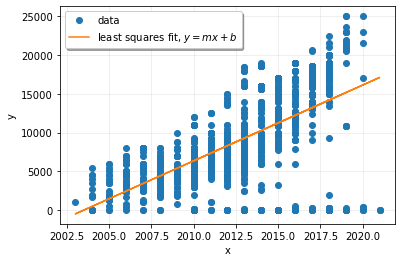

19954260.400388677


In [10]:
import scipy as sp

def fit(data, independent, dependent):
    # These are our independent variable(s)
    x = data[:, independent]
    print(getSummaryStatistics(x))
    print(getShapeType(x))

    # We add a column of 1s for the intercept
    A = x[:, np.newaxis]**[0, 1]
    print(getSummaryStatistics(A))
    print(getShapeType(A))

    # This is the dependent variable 
    y = data[:, dependent]
    print(getSummaryStatistics(y))
    print(getShapeType(y))

    # This is the regression coefficients that were fit, plus some other results
    c, res, _, _ = sp.linalg.lstsq(A, y)

    return c, res

c, res = fit(data, 1, 0)
# this is b and m!
print(c)
plotxyyhat(data[:, 1], data[:, 0], c[1], c[0])
print(msse(data[:, 1], data[:, 0], c[1], c[0]))

## And, this is a function we can use to predict the $y$ (calculate the $\hat{y}$) for new $x$s, so it's a *model*!

For example, my car was a 2018 Mazda 3, so what should its Craigslist price be?

In [10]:
print(c[1]*2010+c[0])

6358.672862506704


*What about your Mazda 3s??*

Of course, this model is based on *historical* car prices, and what has happened over the past year?

Let's collect all our Mazda 3s and make them into a dataset, then let's use that dataset to "evaluate" our model:
* We will take the model we fit (the prediction function we fit) to our *training data*
* We will use it to predict values for the new data, the *test data*
* We will measure how well the model does at predicting

Just above when we fit the model, we calculated $$ A \cdot \vec{c} = \vec{\hat{y}} $$
and we knew $A$ and $\vec{y}$.

Now we know $A$ and $\vec{c}$ and we want to calculate $\vec{\hat{y}}$.

In [11]:
def predict(data, independent, c):
    # These are our independent variable(s)
    x = data[:, independent]
    print(getSummaryStatistics(x))
    print(getShapeType(x))

    # We add a column of 1s for the intercept
    A = x[:, np.newaxis]**[0, 1]
    print(getSummaryStatistics(A))
    print(getShapeType(A))

    return np.dot(A, c)

ourmazdas = np.array([[2018, 2012, 2010]]).T

predict(ourmazdas, 0, c)


[2018 2010 2013]
((3,), dtype('int32'))
[[   1 2018]
 [   1 2010]
 [   1 2013]]
((3, 2), dtype('int32'))


array([14178.602723  ,  8313.65532763,  6358.67286251])

But how good is our regression model? In order to assess this, we would need some *held-out test data with labels*. And then we would calculate how well the regression predictions matched the true prices for the held-out data. In particular, we would calculate $$R^2 = \frac{\sum_{i=1}^N (\hat{y}_i - \bar{y})^2}{\sum_{i=1}^N (y_i - \bar{y})^2}$$
The numerator there tells us the error of the model (vs just calculating the mean of the data) and the denominator tells us the error of the data vs the mean of the data.

In fact, the numerator is the residuals! So we can rewrite this as $$R^2 = \frac{r_i^2}{\sum_{i=1}^N (y_i - \bar{y})^2}$$

Okay, so first let's split our data into *train* and *test*. 

This is actually a little tricky because we know car prices change over time. But we don't know when these ads were posted. So we'll assume they were all posted at about the same time.

In [12]:
(train, test) = np.split(data, [int(len(data) / 10 * 8)])
print(train.shape, test.shape)

(1198, 8) (300, 8)


Then, let's use the *train* data to fit the model, and the *test* data to evaluate it. 

[2021 2003 2012]
((1198,), dtype('int32'))
[[   1 2021]
 [   1 2003]
 [   1 2012]]
((1198, 2), dtype('int32'))
[25000     0  8789]
((1198,), dtype('int32'))
[-1.92589912e+06  9.61334233e+02] 24062253522.741425


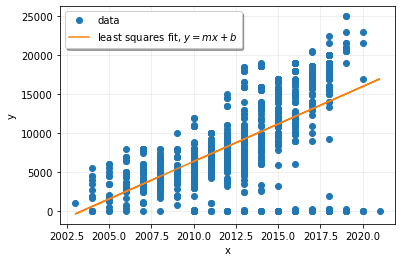

[2021 2004 2012]
((300,), dtype('int32'))
[[   1 2021]
 [   1 2004]
 [   1 2012]]
((300, 2), dtype('int32'))


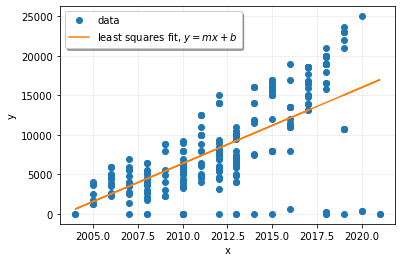

In [13]:
c, res = fit(train, 1, 0)
# this is b and m!
print(c, res)
plotxyyhat(train[:, 1], train[:, 0], c[1], c[0])

yhat = predict(test, 1, c)
plotxyyhat(test[:, 1], test[:, 0], c[1], c[0])

Now that's interesting. The *fit* on the test data does not appear to be as good as the *fit* on the training data. Hmm....

In [14]:
# assume these are numpy arrays
def rsquared(y, yhat):
    if len(y) != len(yhat):
        print("Need y and yhat to be the same length!")
        return 0
    return ((yhat - y.mean())**2).sum() / ((y - y.mean())**2).sum()

yhat = predict(train, 1, c)
print(rsquared(train[:, 0], yhat))
yhat = predict(test, 1, c)
print(rsquared(test[:, 0], yhat))

[2021 2003 2012]
((1198,), dtype('int32'))
[[   1 2021]
 [   1 2003]
 [   1 2012]]
((1198, 2), dtype('int32'))
0.38647859800110784
[2021 2004 2012]
((300,), dtype('int32'))
[[   1 2021]
 [   1 2004]
 [   1 2012]]
((300, 2), dtype('int32'))
0.4009500465888837


How does $R^2$ resemble $MSSE$, and how not? What does $R^2$ look like when the dependent variable is very highly correlated with the independent variable, for example they are the same? What does it look like when they are not at all correlated?

Let's come back to this notion of *correlation*. If two variables are highly *correlated* then a linear regression calculated using one of them as the independent variable and the other as the dependent variable will have *what size of* $R^2$? 

If two variables are highly correlated does this mean one *caused* the other? Why or why not?

 ## Multiple Linear Regression
 
 I want to predict price as a function of age and mileage. After all, an old car with low mileage may be worth more than a new car with high mileage. Actually, I probably want to include some of those other variables (features) too! (Which ones?)
 
It turns out I can do this using multiple linear regression. The function I will want to fit will be:
$$ F(x_{1i}, x_{2i},...,x_{Mi}) = c_0 + c_1x_{1i} + c_2x_{2i} + ... + c_Mx_{Mi} $$
and I do this by minimizing the sum of the squares of the residuals $r_i = y_i-F(x_{1i}, x_{2i},..., x_{Mi})$.

In terms of matrix math, for $N$ data points $A$ will just be a matrix of shape $(N, M+1)$ (including the leading column of 1s) and $\vec{c}$ will have shape $(M+1, 1)$ (including $c_0$, the intercept) and $\vec{y}$ will have shape $(N, 1)$ (as before).

Let's do it! Then, next time we meet let's look at the math behind it!

In [15]:
# Hint: we'll want to adjust fit and predict to take a range of columns from the input data, like: data[np.ix_(np.arange(data.shape[0]), [1,3])]

In [16]:
def fit(data, independent, dependent):
    # These are our independent variable(s)
    x = data[np.ix_(np.arange(data.shape[0]), independent)]
    print(getSummaryStatistics(x))
    print(getShapeType(x))

    # We add a column of 1s for the intercept
    A = np.hstack((np.array([np.ones(x.shape[0])]).T, x))
    print(getSummaryStatistics(A))
    print(getShapeType(A))

    # This is the dependent variable 
    y = data[:, dependent]
    print(getSummaryStatistics(y))
    print(getShapeType(y))

    # This is the regression coefficients that were fit, plus some other results
    # c, res, _, _ = sp.linalg.lstsq(A, y)
    c = solve_normal_equation(A, y)
    return c

def predict(data, independent, c):
    # These are our independent variable(s)
    x = data[np.ix_(np.arange(data.shape[0]), independent)]
    print(getSummaryStatistics(x))
    print(getShapeType(x))

    # We add a column of 1s for the intercept
    A = np.hstack((np.array([np.ones(x.shape[0])]).T, x))
    print(getSummaryStatistics(A))
    print(getShapeType(A))

    return np.dot(A, c)

In [17]:
c, res = fit(data, [1,2,3,5,6,7], 0)

[[  2021      6 264000      3      2     11]
 [  2003     -1     -1     -1      0      0]
 [  2012      2  96565      1      1      3]]
((1498, 6), dtype('int32'))
[[ 1.0000e+00  2.0210e+03  6.0000e+00  2.6400e+05  3.0000e+00  2.0000e+00
   1.1000e+01]
 [ 1.0000e+00  2.0030e+03 -1.0000e+00 -1.0000e+00 -1.0000e+00  0.0000e+00
   0.0000e+00]
 [ 1.0000e+00  2.0120e+03  2.0000e+00  9.6565e+04  1.0000e+00  1.0000e+00
   3.0000e+00]]
((1498, 7), dtype('float64'))
[25000     0  8810]
((1498,), dtype('int32'))


In [18]:
yhat = predict(data, [1,2,3,5,6,7], c)
rsquared(data[:, 0], yhat)

[[  2021      6 264000      3      2     11]
 [  2003     -1     -1     -1      0      0]
 [  2012      2  96565      1      1      3]]
((1498, 6), dtype('int32'))
[[ 1.0000e+00  2.0210e+03  6.0000e+00  2.6400e+05  3.0000e+00  2.0000e+00
   1.1000e+01]
 [ 1.0000e+00  2.0030e+03 -1.0000e+00 -1.0000e+00 -1.0000e+00  0.0000e+00
   0.0000e+00]
 [ 1.0000e+00  2.0120e+03  2.0000e+00  9.6565e+04  1.0000e+00  1.0000e+00
   3.0000e+00]]
((1498, 7), dtype('float64'))


0.5600565362996633

In [19]:
print(c)

[-1.25121656e+06  6.24675988e+02  3.81634866e+02 -2.01944087e-02
  2.05175572e+03  7.63562888e+02  8.06076924e+01]


In [20]:
# and for Amanda's Mazda:
mymazda = np.array([[0, 2018, 3, 40000, 1, 1, 1, 7]])
print(mymazda.shape)
predict(mymazda, [1,2,3,5,6,7], c)

(1, 8)
[[ 2018     3 40000     1     1     7]
 [ 2018     3 40000     1     1     7]
 [ 2018     3 40000     1     1     7]]
((1, 6), dtype('int32'))
[[1.000e+00 2.018e+03 3.000e+00 4.000e+04 1.000e+00 1.000e+00 7.000e+00]
 [1.000e+00 2.018e+03 3.000e+00 4.000e+04 1.000e+00 1.000e+00 7.000e+00]
 [1.000e+00 2.018e+03 3.000e+00 4.000e+04 1.000e+00 1.000e+00 7.000e+00]]
((1, 7), dtype('float64'))


array([13096.28585424])

In [ ]:
def solve_normal_equation(A, y):
    inv = sp.linalg.inv(np.dot(A.T, A))
    part2 = np.dot(A.T, y)
    return np.dot(inv, part2)